# Assignment 3: Dino Fun World Analysis

### Assignment Description

The administrators of Dino Fun World, a local amusement park, have asked you, one of their data analysts, to perform three data analysis tasks for their park. These tasks will involve understanding, analyzing, and graphing attendance data for three days of the park's operations that the park has provided for you to use. They have provided the data in the form of a database.

Part 1: The park's administrators would like your help understanding the different paths visitors take through the park and different rides they visit. In this mission, they have selected five (5) visitors at random whose check-in sequences they would like you to analyze. For now, they would like you to construct a distance matrix for these five visitors. The five visitors have the IDs: 165316, 1835254, 296394, 404385, and 448990.

Part 2: The park's administrators would like to understand the attendance dynamics at each ride (note that not all attractions are rides). They would like to see the minimum (non-zero) attendance at each ride, the average attendance over the whole day, and the maximum attendance for each ride in a parallel coordinate plot.

Part 3: In addition to a parallel coordinate plot, the administrators would like to see a scatterplot matrix depicting the minimum, average, and maximum attendance for each ride as above.

### Directions

The database provided by the park administration is formatted to be readable by any SQL database library. The course staff recommends the sqlite3 library. The database contains three tables, named 'checkin', 'attractions', and 'sequences'. The database file is named 'dinofunworld.db' and is available in the read only directory of the Jupyter Notebook environment (i.e., readonly/dinofunworld.db). It can also be accessed by selecting File > Open > dinofunworld.db.

The information contained in each of these tables is listed below:

`checkin`:
    - The check-in data for all visitors for the day in the park. The data includes two types of check-ins: inferred and actual checkins.
    - Fields: visitorID, timestamp, attraction, duration, type
`attraction`:
    - The attractions in the park by their corresponding AttractionID, Name, Region, Category, and type. Regions are from the VAST Challenge map such as Coaster Alley, Tundra Land, etc. Categories include Thrill rides, Kiddie Rides, etc. Type is broken into Outdoor Coaster, Other Ride, Carussel, etc.
    - Fields: AttractionID, Name, Region, Category, type
`sequences`:
    - The check-in sequences of visitors. These sequences list the position of each visitor to the park every five minutes. If the visitor has not entered the part yet, the sequence has a value of 0 for that time interval. If the visitor is in the park, the sequence lists the attraction they have most recently checked in to until they check in to a new one or leave the park.
    - Fields: visitorID, sequence
    
Using the data provided, perform the required analyses and create the distance matrix, parallel coordinate plot, and scatterplot matrix.


### Submission Directions for Assignment Deliverables

This assignment will be auto-graded. We recommend that you use Jupyter Notebook in your browser to complete and submit this assignment. In order for your answers to be correctly registered in the system, you must place the code for your answers in the cell indicated for each question. In addition, you should submit the assignment with the output of the code in the cell's display area. The display area should contain only your answer to the question with no extraneous information or else the answer may not be picked up correctly.

Each cell that is going to be graded has a set of comment lines at the beginning of the cell. These lines are extremely important and must not be modified or removed. (Graded Cell and PartID comments must be in the same line for proper execution of code.)

Please execute each cell in Jupyter Notebook before submitting.

If you choose to download the file and work on your assignment locally, you can also upload your file to each part in the programming assignment submission space. The file you submit should be named "Assignment_3.ipynb".

### Evaluation

There are three parts in the grading, and each part has one test case where the total number of points for all parts is 3. If some part of your data is incorrect, you will get a partial score of 0.50. If the submission fails, we will return the corresponding error messages. If the submission is correct, you will see "Correct" with 1.0 point for each part.

In [7]:
# Graded Cell, PartID: IiXwN
# Create a distance matrix suitable for use in hierarchical clustering of the
# checkin sequences of the 5 specified visitors. Your distance function should
# count the number of dissimilarities in the sequences without considering any
# other factors. The distance matrix should be reported as a dictionary of
# dictionaries (eg. {1: {2:0, 3:0, 4:0}, 2: {1:0, 3:0, ...}, ...}).

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pandas.plotting import parallel_coordinates, scatter_matrix
import numpy as np

con = sqlite3.connect('readonly/dinofunworld.db')
c = con.cursor()

c.execute("select visitorID, sequence from sequences where visitorID in (165316, 1835254, 296394, 404385, 448990)")
sequences = c.fetchall()
sequences_pd = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequences_pd['sequence_list'] = sequences_pd['sequence'].apply(lambda x: x.split("-"))
outer_dict = {}
for i in range(5):
    for j in range(i+1, 5):
        dist = sum(int(v1) != int(v2) for v1, v2 in zip(sequences_pd['sequence_list'][i], sequences_pd['sequence_list'][j]))
        id_i = sequences_pd['visitor'][i]
        id_j = sequences_pd['visitor'][j]
        innerDict_i = outer_dict.get(id_i, {})
        innerDict_i[id_j] = dist
        outer_dict[id_i] = innerDict_i
        innerDict_j = outer_dict.get(id_j, {})
        innerDict_j[id_i] = dist
        outer_dict[id_j] = innerDict_j
print(outer_dict)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


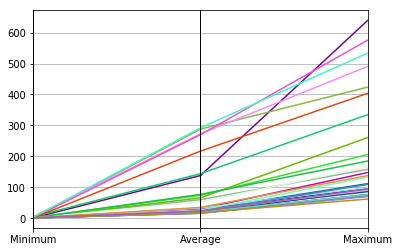

                         Ride Minimum Average Maximum
0      Wrightiraptor Mountain       1      60     158
1          Galactosaurus Rage       1      66     261
2          Auvilotops Express       1     138     640
3                  TerrorSaur       2     288     424
4           Wendisaurus Chase       5     273     491
5        Keimosaurus Big Spin       2      74     206
6                    Firefall       1     270     576
7                   Atmosfear       5     144     335
8                  North Line       1      53     166
9             Jeredactyl Jump       1      26     112
10            Sauroma Bumpers       1      30     148
11       Flying TyrAndrienkos       1      24      98
12       Cyndisaurus Asteroid       1      16      72
13                 Beelzebufo       1      18      93
14       Enchanted Toadstools       1      16      77
15                Stegocycles       1      17      76
16             Blue Iguanodon       1      17      73
17         Wild Jungle Cruis

In [16]:
# Graded Cell, PartID: 8S2jm
# Create and display a Parallel Coordinate Plot displaying the minimum, average, 
# and maximum attendance for each ride in the park (note that not all attractions
# are rides).

c.execute("select attractionId, name from attraction where lower(category) like ('%ride%')")
ride_dict = {}
ride_name_dict = {}
for item in c.fetchall():
    ride_dict[item[0]] = Counter()
    ride_name_dict[item[0]] = item[1]
    
c.execute("SELECT * from sequences")
for i in c.fetchall():
    sequence = i[2]
    for i, item in enumerate(sequence.split("-")):
        if int(item) in ride_dict:
            ride_dict[int(item)][i] += 1

attendance_pd = pd.DataFrame(columns=['Ride', 'Minimum', 'Average', 'Maximum'])
count = 0
for ride in ride_dict:
    minimum = min(ride_dict[ride].values())
    maximum = max(ride_dict[ride].values())
    average = int(sum(ride_dict[ride].values()) / len(ride_dict[ride].values()))
    ride_name = ride_name_dict[ride]
    attendance_pd.loc[count] = [ride_name, minimum, average, maximum]
    count += 1

parallel_coordinates(attendance_pd, class_column='Ride', cols=['Minimum', 'Average', 'Maximum'])
plt.gca().legend_.remove()
plt.show()
print(attendance_pd)

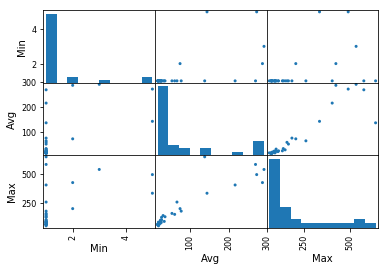

                         Ride  Min  Avg  Max
0      Wrightiraptor Mountain    1   60  158
1          Galactosaurus Rage    1   66  261
2          Auvilotops Express    1  138  640
3                  TerrorSaur    2  288  424
4           Wendisaurus Chase    5  273  491
5        Keimosaurus Big Spin    2   74  206
6                    Firefall    1  270  576
7                   Atmosfear    5  144  335
8                  North Line    1   53  166
9             Jeredactyl Jump    1   26  112
10            Sauroma Bumpers    1   30  148
11       Flying TyrAndrienkos    1   24   98
12       Cyndisaurus Asteroid    1   16   72
13                 Beelzebufo    1   18   93
14       Enchanted Toadstools    1   16   77
15                Stegocycles    1   17   76
16             Blue Iguanodon    1   17   73
17         Wild Jungle Cruise    1   19   90
18                 Stone Cups    1   16   70
19            Scholtz Express    1   77  185
20       Paleocarrie Carousel    1   33   99
21        

In [18]:
# Graded Cell, PartID: KHoww
# Create and display a Scatterplot Matrix displaying the minimum, average, and 
# maximum attendance for each ride in the park.
# Note: This is a different view into the same data as the previous part. While
# you work on these plots, consider the different things that each chart says
# about the data.

c.execute("select attractionId, name from attraction where lower(category) like ('%ride%')")
ride_dict = {}
ride_name_dict = {}
for item in c.fetchall():
    ride_dict[item[0]] = Counter()
    ride_name_dict[item[0]] = item[1]
    
c.execute("SELECT * from sequences")
for i in c.fetchall():
    sequence = i[2]
    for i, item in enumerate(sequence.split("-")):
        if int(item) in ride_dict:
            ride_dict[int(item)][i] += 1

attendance = []
for ride in ride_dict:
    minimum = min(ride_dict[ride].values())
    maximum = max(ride_dict[ride].values())
    average = int(sum(ride_dict[ride].values()) / len(ride_dict[ride].values()))
    ride_name = ride_name_dict[ride]
    attendance.append([ride_name, minimum, average, maximum])
    count += 1
attendance_pd = pd.DataFrame(attendance, columns = ['Ride', 'Min', 'Avg', 'Max'])
    
scatter_matrix(attendance_pd, alpha=1)
plt.show()
print(attendance_pd)